# Slow waves analysis

## Introductory notes:
This notebook presents slow waves detection functionality.

Recommended reading:
1. [YASA: FAQ](https://raphaelvallat.com/yasa/build/html/faq.html#event-detection)
2. [YASA: Slow-waves detection](https://github.com/raphaelvallat/yasa/blob/master/notebooks/05_sw_detection.ipynb)
3. [YASA: Multi-channel slow-wave detection](https://github.com/raphaelvallat/yasa/blob/master/notebooks/06_sw_detection_multi.ipynb)
4. [YASA: SWResults class](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html#yasa-swresults)
5. [MNE: Time-frequency analysis: power and inter-trial coherence](https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#time-frequency-analysis-power-and-inter-trial-coherence)
6. [MNE: AverageTFR class](https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html#mne-time-frequency-averagetfr)

## Import module

In [ ]:
from sleepeegpy.pipeline import SlowWavesPipe
from joblib import parallel_backend

parallel_backend("loky", n_jobs=-1)
from os import makedirs, path

## Slow waves detection

If you wish to change the path for output_dir ot input dir, change it below.
If no such folders, they will be created automatically.

In [ ]:
output_dir = "output_folder"  # Output path and name can be changed here
input_dir = "input_files"  # input files dir can be changed here
makedirs(input_dir, exist_ok=True)
makedirs(output_dir, exist_ok=True)

#### Add required files and data
* Put all your files in the input folder.
* Modify your eeg file name below. The file can be any format supported by the mne.read_raw() function.
* Modify your hypnogram file name below
* Make sure the hypno_freq is the right frequency.
* For more information about the supported formats, see [mne documentation](https://mne.tools/stable/generated/mne.io.Raw.html)

In [ ]:
eeg_file_name = "resampled_raw.fif"  # None # add your eeg_path here
hypnogram_filename = "staging.txt"  # Hypnogram filename can be changed here (file must be in the input dir)
hypno_freq = 1

In [ ]:
path_to_eeg = path.join(input_dir, eeg_file_name)
hypnogram_path = path.join(input_dir, hypnogram_filename)

assert path.isfile(path_to_eeg) and path.isfile(
    hypnogram_path
), f"{path_to_eeg} or {hypnogram_path} not exist"
slow_waves_pipe = SlowWavesPipe(
    path_to_eeg=path_to_eeg,
    output_dir=output_dir,
    path_to_hypno=hypnogram_path,
    hypno_freq=hypno_freq,
)

Please refer to the YASA's [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.sw_detect.html) for details about the arguments.

In [ ]:
slow_waves_pipe.detect(
    picks=["eeg"],
    reference="average",
    include=(2, 3),
    freq_sw=(0.3, 1.5),
    dur_neg=(0.3, 1.5),
    dur_pos=(0.1, 1),
    amp_neg=(40, 200),
    amp_pos=(10, 150),
    amp_ptp=(75, 350),
    coupling=False,
    coupling_params={"freq_sp": (12, 16), "p": 0.05, "time": 1},
    remove_outliers=False,
    verbose=False,
    save=True,
)

Please refer to the YASA's [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.SWResults.html) for details about the arguments.

In [ ]:
slow_waves_pipe.results.summary(
    grp_chan=False, grp_stage=True, mask=None, aggfunc="mean", sort=True
)

Count     Density  Duration  ValNegPeak  ValPosPeak         PTP  \
Stage                                                                     
2        7617   69.561644  1.278879  -68.369328   39.043891  107.413219   
3      132955  696.099476  1.259195  -61.891508   46.102154  107.993663   

            Slope  Frequency  
Stage                         
2      364.222711   0.826626  
3      379.508453   0.843116

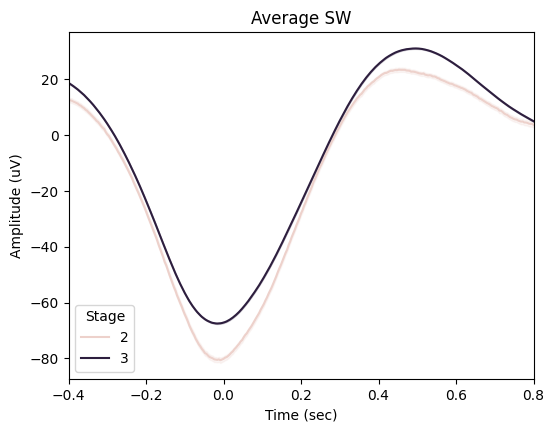

In [ ]:
slow_waves_pipe.plot_average(
    save=True,
    center="NegPeak",
    hue="Stage",
    time_before=0.4,
    time_after=0.8,
    filt=(None, None),
    mask=None,
)

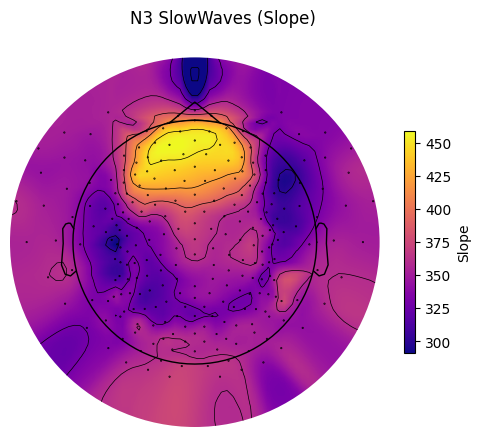

In [ ]:
slow_waves_pipe.plot_topomap(
    prop="Slope",  #  Any of the event properties returned by pipe.results.summary().
    stage="N3",  # Stage to plot the topomap for.
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Should contain at least index of the provided "stage".
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    axis=None,  # Whether to plot on provided matplotlib axis.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

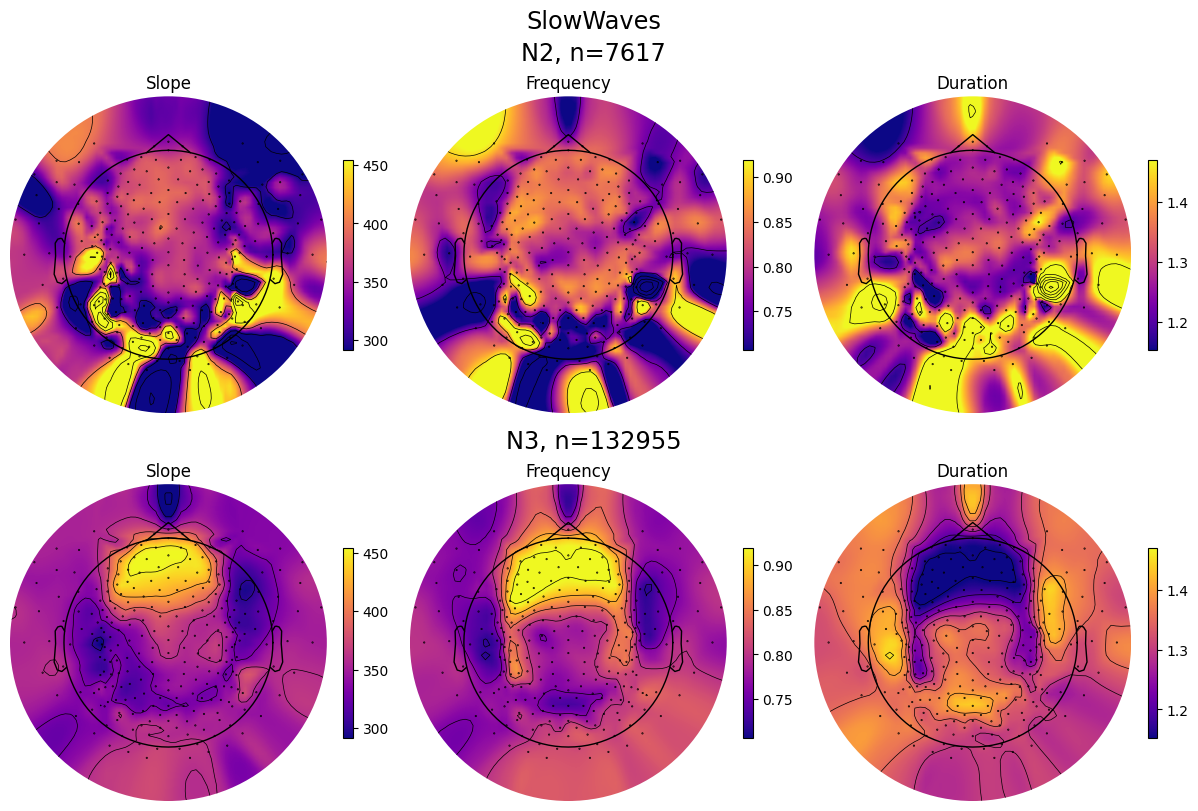

In [ ]:
slow_waves_pipe.plot_topomap_collage(
    # Some of the event properties returned by pipe.results.summary().
    props=["Slope", "Frequency", "Duration"],
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    # Should contain at least indices of the provided "stages_to_plot".
    sleep_stages={"N2": 2, "N3": 3},
    low_percentile=5,  # Set min color value by percentile of the property data.
    high_percentile=95,  # Set max color value by percentile of the property data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

Constructs MNE [AverageTFR](https://mne.tools/stable/generated/mne.time_frequency.AverageTFR.html) object for every available sleep stage.

In [ ]:
slow_waves_pipe.compute_tfr(
    freqs=(0.5, 5),  # Interval of frequencies of interest.
    n_freqs=100,  # TFR frequency resolution.
    time_before=4,  # Time in sec before the peak to use in TFR computation. Should be positive.
    time_after=4,  # Time in sec after the peak to use in TFR computation.
    method="morlet",  # TFR method: 'morlet' or 'multitaper'.
    save=True,  # Whether to save AverageTFR object per sleep stage as hdf5 file.
    overwrite=False,  # Whether to overwrite existing files.
    n_cycles=2,
)

slow_waves_pipe.tfrs

In [ ]:
slow_waves_pipe.tfrs["N2"].data

array([[[  8327.17479164,   8409.2589031 ,   8491.94287836, ...,
          35404.27956195,  35156.87008082,  34909.20265543],
        [  7357.64827015,   7427.39297607,   7497.53071526, ...,
          32679.58351747,  32432.94438208,  32185.96662475],
        [  6789.54824771,   6851.55713286,   6913.75284223, ...,
          30179.76435424,  29936.52542406,  29692.83521332],
        ...,
        [  1834.03019877,   1935.24222045,   2029.3149276 , ...,
           3261.51799011,   3115.19503396,   2958.17948907],
        [  1820.85763462,   1922.53721692,   2017.05615833, ...,
           3222.94326212,   3078.62157465,   2923.30844848],
        [  1807.65889687,   1909.77336246,   2004.70576662, ...,
           3185.54221483,   3043.18328126,   2889.52841916]],

       [[ 24202.70709394,  24399.36885866,  24596.37251036, ...,
          50321.90782328,  50012.82627733,  49704.93615338],
        [ 21941.35811797,  22131.20507941,  22321.34274969, ...,
          45206.75603714,  44972.73750

In [ ]:
slow_waves_pipe.tfrs["N2"].to_data_frame()

time  freq           E1           E10          E100          E101  \
0      -4.000   0.5  8327.174792  24202.707094  48924.736669  39136.709413   
1      -3.996   0.5  8409.258903  24399.368859  49281.102763  39406.336499   
2      -3.992   0.5  8491.942878  24596.372510  49637.322267  39675.597990   
3      -3.988   0.5  8575.230882  24793.703990  49993.360119  39944.465872   
4      -3.984   0.5  8659.127428  24991.348688  50349.181273  40212.912122   
...       ...   ...          ...           ...           ...           ...   
200095  3.984   5.0  3429.901500  11262.392110   8186.597511   9503.453968   
200096  3.988   5.0  3314.909209  11047.257251   7949.896955   9172.306963   
200097  3.992   5.0  3185.542215  10759.126606   7670.569782   8801.089724   
200098  3.996   5.0  3043.183281  10403.328748   7352.799803   8394.451726   
200099  4.000   5.0  2889.528419   9986.653453   7001.555157   7957.730378   

                E102          E103          E104          E105  ...  \
0       16565.769149  21032.257004  16297.561439  14364.987680  ...   
1       16708.449758  21202.065016  16443.286671  14494.296028  ...   
2       16851.524047  21372.206949  16589.601708  14624.177349  ...   
3       16994.982900  21542.672288  16736.502345  14754.629653  ...   
4       17138.817163  21713.450432  16883.984341  14885.651000  ...   
...              ...           ...           ...           ...  ...   
200095   8531.528837   6867.098126   4830.527870   2719.352112  ...   
200096   8194.028659   6609.685367   4635.594985   2607.184777  ...   
200097   7824.249030   6324.156979   4425.367535   2485.573841  ...   
200098   7426.868327   6014.294154   4201.815750   2355.866277  ...   
200099   7007.049233   5684.317901   3967.230976   2219.598580  ...   

                 E91           E92           E93            E94          E95  \
0       18311.186857  11788.543531  10151.399608  813004.188548  6635.561922   
1       18444.541127  11887.000917  10243.375095  826935.307053  6700.255489   
2       18577.913438  11985.771994  10335.765080  841068.344747  6765.308494   
3       18711.293518  12084.854022  10428.569612  855405.572419  6830.719970   
4       18844.671407  12184.245884  10521.787122  869949.275252  6896.489029   
...              ...           ...           ...            ...          ...   
200095   7957.036605   4867.406478   1872.140713    6163.467729  8182.874264   
200096   7734.217197   4668.399175   1808.386104    6018.772218  7918.656800   
200097   7469.392018   4450.939737   1736.459351    5839.955716  7613.461919   
200098   7166.566486   4217.945319   1657.303549    5629.285089  7272.190910   
200099   6830.508999   3972.575648   1571.995078    5389.834376  6900.349854   

                 E96            E97            E98           E99          VREF  
0        9187.194787  128842.213203  212463.813057  23333.863418  23821.186402  
1        9311.619642  130066.366501  214330.539209  23559.758544  23974.795983  
2        9437.310772  131292.465082  216200.683458  23786.637260  24127.883242  
3        9564.273811  132520.345609  218074.077555  24014.490320  24280.428790  
4        9692.514330  133749.841216  219950.553685  24243.307984  24432.413277  
...              ...            ...            ...           ...           ...  
200095  42196.721683    2753.857842    2645.100466   6920.765242   3162.336643  
200096  41436.814301    2675.732279    2570.668662   6734.209980   3021.996150  
200097  40400.796093    2582.723509    2482.027288   6506.794214   2871.973323  
200098  39108.043828    2476.376797    2380.632657   6242.906538   2713.981375  
200099  37583.368617    2358.483433    2268.170865   5947.554626   2549.860924  

[200100 rows x 259 columns]

No baseline correction applied


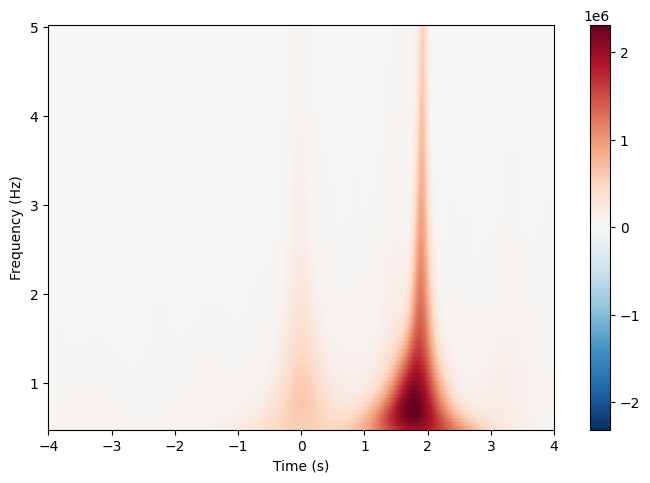

No baseline correction applied


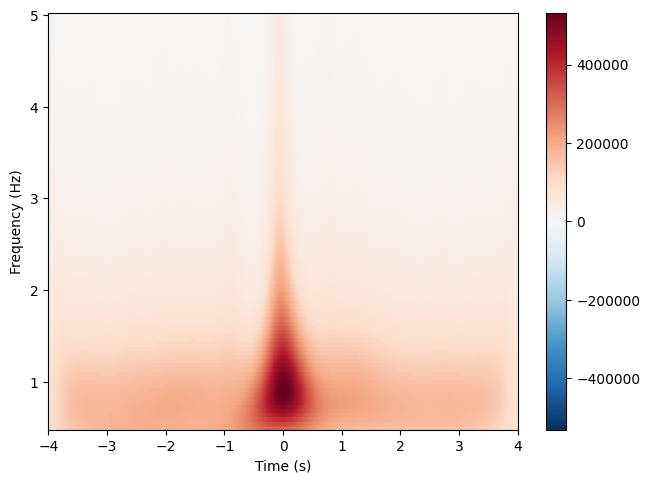

[<Figure size 640x480 with 2 Axes>]

In [ ]:
slow_waves_pipe.tfrs["N2"].plot(["E101"]),
slow_waves_pipe.tfrs["N3"].plot(["E101"])

If you want to load saved TFR files:

In [ ]:
slow_waves_pipe.read_tfrs(dirpath=None)